In [2]:
import keras
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-05-05 22:33:10.929854: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 22:33:11.253122: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-05 22:33:11.254425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 22:33:12.487592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
scaler = StandardScaler()
df_original =pd.read_csv('GAIL.NS.csv').drop(columns=['Date','Adj Close']).dropna()
scaler.fit(df_original)
df = pd.DataFrame()
df[df_original.columns] = scaler.transform(df_original)
val = df[-5:]

In [4]:
def create_sequence(X, n_future , n_past):
    X = X[list(X)[:]].astype(float)
    #print(X)
    trainX = []
    trainY = []
    for i in range(n_past, len(X) - n_future +1):
        trainX.append(X[i - n_past:i])
        trainY.append(X[i + n_future - 1:i + n_future]['Close'])
    return np.array(trainX), np.array(trainY)

In [5]:
X_train, y_train = create_sequence(df[:-30],15,70)

In [6]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

2023-05-05 22:33:14.334829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-05 22:33:14.557890: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
1284/1284 [==============================] - 37s 27ms/step - loss: 0.0437 - val_loss: 0.0660
Epoch 2/5
1284/1284 [==============================] - 39s 30ms/step - loss: 0.0434 - val_loss: 0.0561
Epoch 3/5
1284/1284 [==============================] - 39s 31ms/step - loss: 0.0347 - val_loss: 0.0977
Epoch 4/5
1284/1284 [==============================] - 40s 31ms/step - loss: 0.0316 - val_loss: 0.0494
Epoch 5/5
1284/1284 [==============================] - 39s 31ms/step - loss: 0.0304 - val_loss: 0.0564


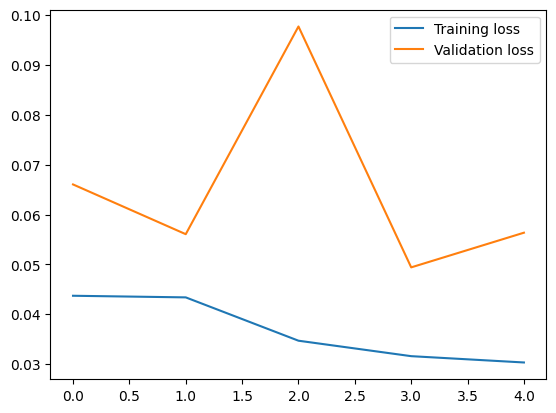

In [7]:
history = model.fit(X_train, y_train, epochs=5, batch_size=4, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [8]:
prediction = model.predict(create_sequence(df[-99:],0,70)[0])
prediction_copies = np.repeat(prediction, 5, axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

1/1 [==============================] - 0s 241ms/step


In [9]:
print(y_pred_future.shape)
forecast_dates = [x for x in range(30)]
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
original = df_original[['Close']]
original = original[-30:]
original['Date'] = forecast_dates

(30,)


<AxesSubplot: xlabel='Date', ylabel='Close'>

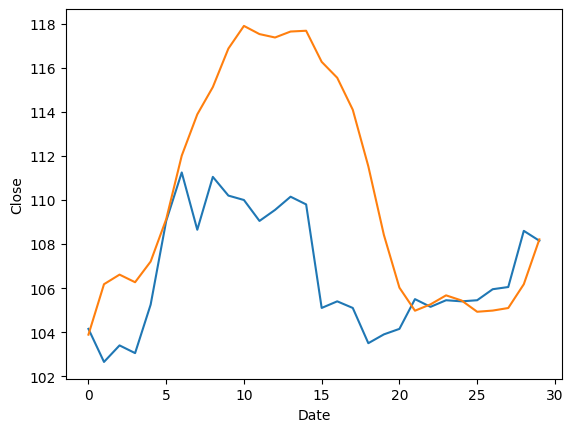

In [10]:
import seaborn as sns
sns.lineplot(x = original['Date'], y = original['Close'], legend = True, markers = '*')
sns.lineplot(x = df_forecast['Date'], y = df_forecast['Close'])
#sns.pointplot(x = original['Date'], y = np.array(original['Close'])-np.array(df_forecast['Close']))